### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [40]:
import os

import pandas as pd
import xgboost as xgb

In [41]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 2.2.2
xgboost version: 2.0.3


In [42]:
# if pd.__version__ != "1.5.1":
#     os.system("pip install pandas==1.5.1")

In [43]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [44]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data loading (my full table)

In [45]:
train = pd.read_csv('./data/train.csv', parse_dates=['ds'])

In [46]:
valid = pd.read_csv('./data/valid.csv', parse_dates=['ds'])
test = pd.read_csv('./data/test.csv', parse_dates=['ds'])

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [47]:
train.set_index("unique_id", inplace = True)
valid.set_index("unique_id", inplace = True)
test.set_index("unique_id", inplace = True)

In [48]:
train.sample(5)

,ds,monthly_average_price,y,year,quarter,around_Xmas,month_sin,month_cos,item_id_y_sum_lag1,item_id_y_sum_lag2,...,cluster_3,ytd_sales,monthly_to_month_sales,quarterly_sales,sales_ratio,price_change,city_id,shop_id,item_category_id,item_id
unique_id,,,,,,,,,,,,,,,,,,,,,
38_2308,2014-07-31,298.833333,4.0,2014,3,0,-5.000000e-01,-0.866025,123.0,151.0,...,6.449725,33.0,6.0,18.0,1.500000,-0.166667,4.867188,4.867188,5.591933,5.978009
16_7893,2014-10-31,1990.000000,3.0,2014,4,0,-8.660254e-01,0.500000,57.0,85.0,...,10.444997,40.0,9.0,19.0,1.200000,200.125000,6.502841,6.502841,5.551471,5.565104
19_20949,2015-06-30,5.000000,30.0,2015,2,0,1.224647e-16,-1.000000,633.0,675.0,...,48.759682,148.0,90.0,261.0,0.166667,0.000000,6.627232,6.627232,25.494565,25.494565
52_5820,2015-05-31,3199.000000,1.0,2015,2,0,5.000000e-01,-0.866025,27.0,31.0,...,13.165631,14.0,5.0,13.0,2.000000,0.000000,5.018750,3.600694,7.524916,4.619792
57_4244,2013-12-31,999.000000,24.0,2013,4,1,-2.449294e-16,1.000000,35.0,29.0,...,13.239814,142.0,24.0,45.0,0.133333,0.000000,6.351786,6.328869,5.696875,6.562500


In [49]:
X_train = train.drop(['y', "ds"], axis=1)
Y_train = train['y']

X_valida = valid.drop(['y', "ds"], axis=1)
Y_valida = valid['y']

X_test = test.drop(['y', "ds"], axis=1)

<a id='model_train'></a>
# Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [50]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
          verbose = True, early_stopping_rounds = 10)

[0]	validation_0-rmse:5.81566	validation_1-rmse:5.62265
[1]	validation_0-rmse:4.40076	validation_1-rmse:4.43898
[2]	validation_0-rmse:3.43127	validation_1-rmse:3.71884


c:\Users\UX433F\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:2.81622	validation_1-rmse:3.34760
[4]	validation_0-rmse:2.41028	validation_1-rmse:3.04243
[5]	validation_0-rmse:2.13433	validation_1-rmse:2.91587
[6]	validation_0-rmse:1.96290	validation_1-rmse:2.83312
[7]	validation_0-rmse:1.84598	validation_1-rmse:2.80263
[8]	validation_0-rmse:1.76116	validation_1-rmse:2.77558
[9]	validation_0-rmse:1.69857	validation_1-rmse:2.77319
[10]	validation_0-rmse:1.65265	validation_1-rmse:2.75223
[11]	validation_0-rmse:1.58889	validation_1-rmse:2.74815
[12]	validation_0-rmse:1.54620	validation_1-rmse:2.73945
[13]	validation_0-rmse:1.52072	validation_1-rmse:2.72429
[14]	validation_0-rmse:1.48552	validation_1-rmse:2.70519
[15]	validation_0-rmse:1.45967	validation_1-rmse:2.70238
[16]	validation_0-rmse:1.42870	validation_1-rmse:2.74371
[17]	validation_0-rmse:1.40721	validation_1-rmse:2.73319
[18]	validation_0-rmse:1.37572	validation_1-rmse:2.70487
[19]	validation_0-rmse:1.34935	validation_1-rmse:2.69791
[20]	validation_0-rmse:1.33230	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

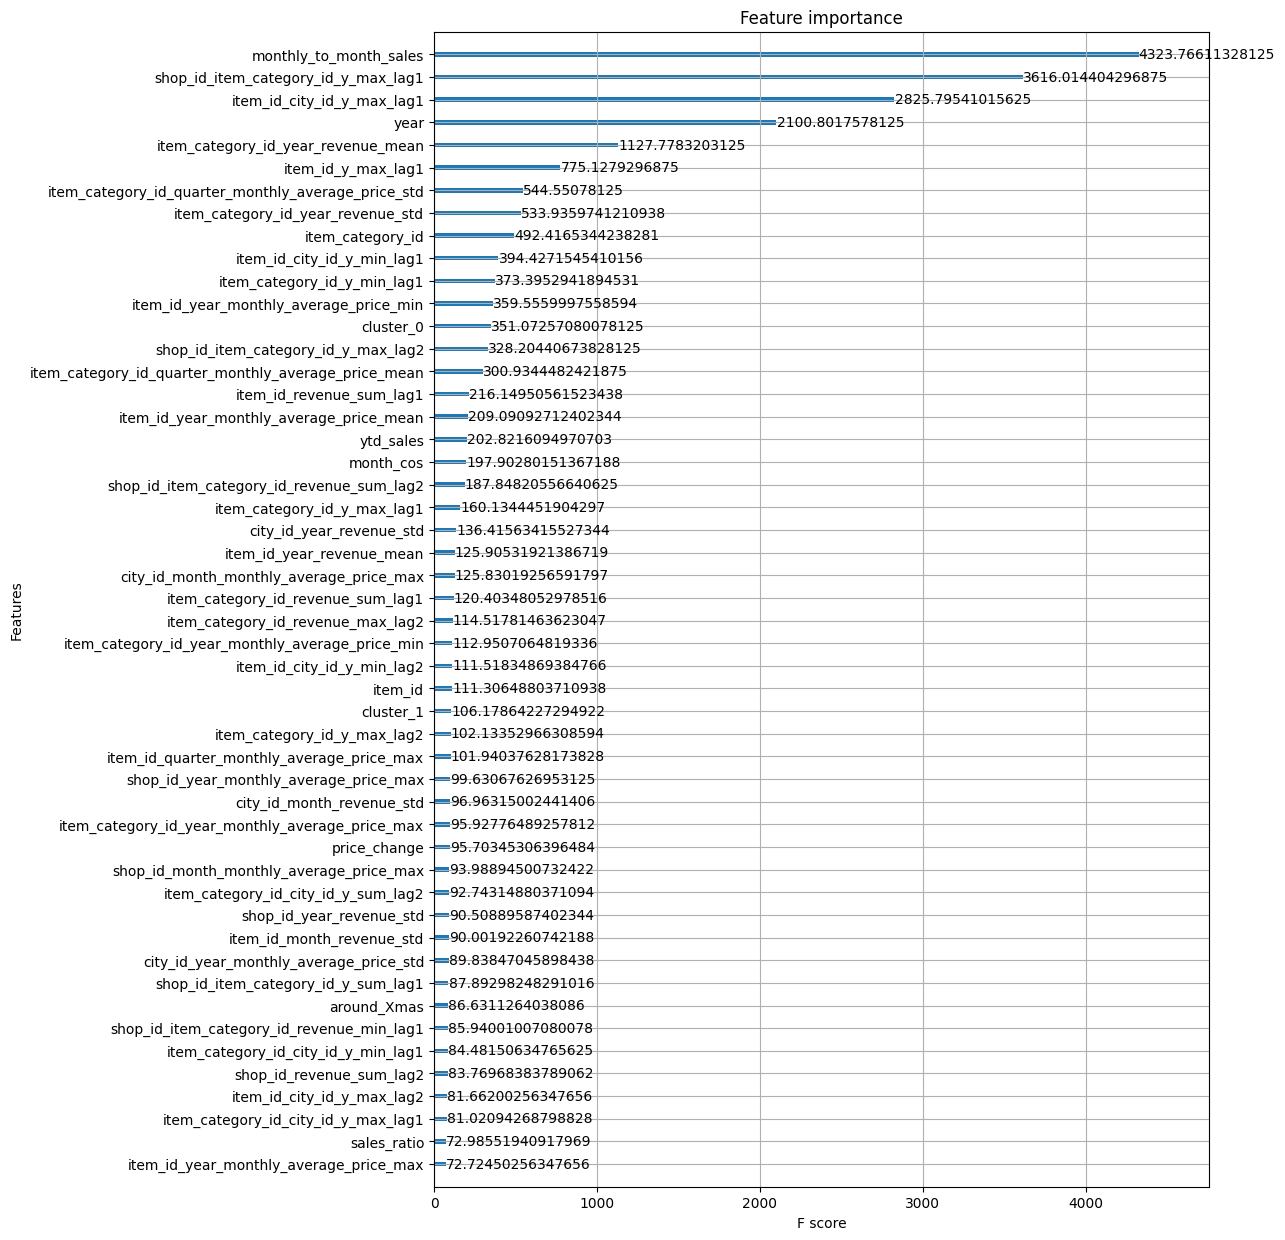

In [51]:
fig, ax = plt.subplots(figsize=(10, 15))
xgb.plot_importance(model, importance_type="gain", ax=ax, max_num_features=50)
plt.show()

In [52]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [53]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 1_114
Validation RMSE: 2_653


In [54]:
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

X_test.reset_index(inplace = True)

X_test[["unique_id", "monthly_sales"]].to_csv(f"./submissions/nico_notbook_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}_rmse_{rmse_valida}.csv", index=False)


<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)